Importamos la libreria Gym con la que trabajaremos.

In [5]:
!apt update
!apt install -y xvfb
!pip install -U pyvirtualdisplay
!pip install gym
!pip install atari_py

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 2s (141 kB/s)
Reading package lis

In [6]:
import gym
import tensorflow as tf
from tensorflow import keras
from keras import layers
assert tf.__version__ >= "2.0"
import sklearn
import gym
import numpy as np
import random
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from collections import deque

Establecemos el entorno deseado, que en nuestro caso es el de Breakout

In [7]:
!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/

--2022-05-08 11:38:54--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19583716 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.2’

Roms.rar.2          100%[===================>]  18.68M   481KB/s    in 41s     

2022-05-08 11:39:35 (467 KB/s) - ‘Roms.rar.2’ saved [19583716/19583716]

mkdir: cannot create directory ‘/content/ROM/’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar


Would you like to replace the existing file /content/ROM/128 in 1 Game Select ROM (Unknown) ~.bin
  2048 bytes, modified on 2017-11-20 22:54
with a new one
  2048 bytes, modified on 2017-11-20 22:54

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/ROM/128 in 1 Game Select ROM (Unknown) ~.bin          0%

Ponemos todo bonito para las visualizaciones:

In [8]:
env = gym.make("Breakout-v0")

In [9]:
mpl.rc('axes', labelsize=28)
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)
mpl.rc('animation', html='jshtml')

In [10]:
env.seed(2022)
obs = env.reset()
obs

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

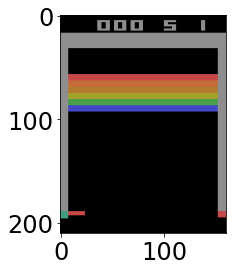

In [11]:
for i in range(22):
  if i > 20:
    plt.imshow(obs)
    plt.show()


  obs, puntuacion, muerto, vidas = env.step(3)
  

In [12]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [13]:
env.observation_space.shape

(210, 160, 3)

In [14]:
env.action_space.n

4

In [15]:
env.render()

True

In [16]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

# Creamos la CNN Double Deep Q-Network

In [18]:
# Reseteamos todo lo que hayamos hecho hasta ahora
keras.backend.clear_session()

# Establecemos una seed para los diferentes paquetes que nos importan
tf.random.set_seed(41)
np.random.seed(41)

# Definimos nuestro entorno
env = gym.make('Breakout-v0')

In [19]:
# El input lo hemos obtenido antes
input_shape = [210, 160, 3] 

# El número de outputs debe coincidir con el número de posibles acciones
n_outputs = 4 
K = keras.backend
input_states = keras.layers.Input(shape=input_shape)
x = keras.layers.Conv2D(64, kernel_size=3, input_shape = input_shape, activation="elu")(input_states)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv2D(128, kernel_size=3,activation="elu")(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Flatten()(x)     

x = keras.layers.Dense(128, activation="elu")(x)

state_values = keras.layers.Dense(1)(x)
raw_advantages = keras.layers.Dense(n_outputs)(x)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.Huber()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 210, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 208, 158, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 104, 79, 64)  0           ['conv2d[0][0]']                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
# Establecemos una función para la politica de seleccion de accion
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [21]:
# Establecemos container de longitud maxima 200000
replay_memory = deque(maxlen=200000)

In [22]:
def sample_experiences(batch_size):
    # Escogemos n = batch_size de indices de forma aleatoria
    indices = np.random.randint(len(replay_memory), size=batch_size)
    # Definimos el conjunto de batch con los indices obtenidos
    batch = [replay_memory[index] for index in indices]
    # Sacamos los datos de la memoria del conjunto de batch 
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [23]:
def play_one_step(env, state, epsilon):
    # Tomamos una acción siguiendo la política establecida
    action = epsilon_greedy_policy(state, epsilon)
    # Guardamos los datos obtenidos tras tomar esa accion
    next_state, reward, done, info = env.step(action)
    # Añadimos la lista a la memoria
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [24]:
batch_size = 32
discount_rate = 0.95

def training_step(batch_size):
    # Sacamos las experiencias del conjunto aleatorio de batch de tamaño 
    # de batch size.
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    # Sacamos los proximos Q-valores con los proximos estados obtenidos 
    # al tomar la acción
    next_Q_values = model.predict(next_states)
    # Sacamos el valor maximo de los Q-valores
    max_next_Q_values = np.max(next_Q_values, axis=1)
    # Aplicamos la formula y modificamos la estructura
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    # Devolvemos un tensor que sera mask
    mask = tf.one_hot(actions, n_outputs)



    
    # No se que hace....
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [25]:
env.seed(41)
np.random.seed(41)
tf.random.set_seed(41)

In [26]:
# Generamos un par de listas para guardar datos y asignamos la mejor
# puntuación inicial como 0
best_score = 0
rewards = []
best_weights = []

# Iteramos por episodios y dentro de el por pasos
for episode in range(350):
    episode_rewards = 0
    obs = env.reset()    
    for step in range(5000):
        # Actualizamos el valor de epsilon en función del episodio
        epsilon = max(1 - episode / 650, 0.01)
        # Sacamos los datos tras el primer paso
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        # Actualizamos el valor de recompensas del episodio
        episode_rewards += reward   
        # En caso de llegar a estado terminal paramos
        if done:
            break
    # Añadimos la recompensa del episodio a la lista de recompensas
    rewards.append(episode_rewards) 
    # En caso de mejorar los mejores resultados asignamos los pesos y el score
    # conseguido
    if episode_rewards > best_score: 
        best_weights = model.get_weights() 
        best_score = episode_rewards 
    # Printeamos los resultados obtenidos en el episodio
    print("\rEpisode: {}, Episode_Rewards: {}, eps: {:.3f}, best_score: {}".format(episode, episode_rewards, epsilon, best_score)) 
    # En caso de llevar mas de 50 episodios realizamos ....
    if episode > 50:
        training_step(batch_size)

# Establecemos como pesos del modelo los mejores pesos
model.set_weights(best_weights)

Episode: 0, Episode_Rewards: 0.0, eps: 1.000, best_score: 0
Episode: 1, Episode_Rewards: 1.0, eps: 0.998, best_score: 1.0
Episode: 2, Episode_Rewards: 0.0, eps: 0.997, best_score: 1.0
Episode: 3, Episode_Rewards: 2.0, eps: 0.995, best_score: 2.0
Episode: 4, Episode_Rewards: 1.0, eps: 0.994, best_score: 2.0
Episode: 5, Episode_Rewards: 0.0, eps: 0.992, best_score: 2.0
Episode: 6, Episode_Rewards: 2.0, eps: 0.991, best_score: 2.0
Episode: 7, Episode_Rewards: 0.0, eps: 0.989, best_score: 2.0
Episode: 8, Episode_Rewards: 2.0, eps: 0.988, best_score: 2.0
Episode: 9, Episode_Rewards: 1.0, eps: 0.986, best_score: 2.0
Episode: 10, Episode_Rewards: 1.0, eps: 0.985, best_score: 2.0
Episode: 11, Episode_Rewards: 1.0, eps: 0.983, best_score: 2.0
Episode: 12, Episode_Rewards: 0.0, eps: 0.982, best_score: 2.0
Episode: 13, Episode_Rewards: 0.0, eps: 0.980, best_score: 2.0
Episode: 14, Episode_Rewards: 2.0, eps: 0.978, best_score: 2.0
Episode: 15, Episode_Rewards: 0.0, eps: 0.977, best_score: 2.0
Epis

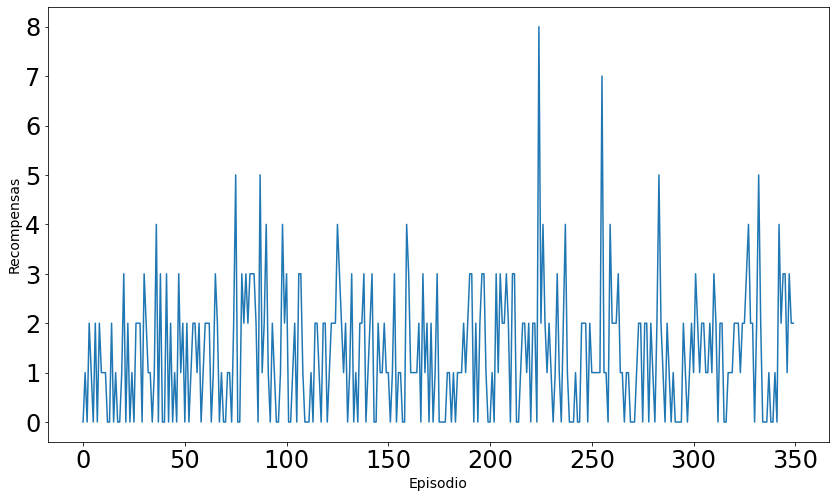

In [27]:
plt.figure(figsize=(14, 8))
plt.plot(rewards)
plt.xlabel("Episodio", fontsize=14)
plt.ylabel("Recompensas", fontsize=14)
#save_fig("dqn_rewards_plot")
plt.show()